In [1]:
import os
import subprocess
import pandas as pd
import platform
import pathlib
import numpy as np
from annotations import *
from extract_video_features import *
from extract_audio_features import *
import cv2
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.metrics import f1_score
import importlib
from tqdm import tqdm
import ordinal_classification as o_c
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


In [2]:
#get current directory
cwd = os.getcwd()

In [3]:
cwd

'/Users/valentinadiproietto/filrouge'

In [4]:
OpenFace_folder = '/Users/valentinadiproietto/OpenFace'
filename_annotations = 'https://docs.google.com/spreadsheets/d/1Rqu1sJiD-ogc4a6R491JTiaYacptOTqh6DKqhwTa8NA/gviz/tq?tqx=out:csv&sheet=Template'

In [5]:
Video_folder = '/Users/valentinadiproietto/Desktop/video_stress'

In [6]:
video_paths, video_names = get_videos(Video_folder)

In [7]:
video_names

['WIN_20210331_21_22_52_Pro',
 'WIN_20210329_14_13_45_Pro',
 'WIN_20210406_18_49_10_Pro',
 'WIN_20210408_14_11_32_Pro',
 'WIN_20210408_15_20_51_Pro',
 'WIN_20210404_10_58_27_Pro',
 'WIN_20210414_06_24_52_Pro',
 'WIN_20210406_15_06_15_Pro',
 'WIN_20210417_14_53_12_Pro',
 'WIN_20210413_15_38_01_Pro',
 'WIN_20210408_11_48_58_Pro',
 'WIN_20210408_16_04_32_Pro',
 'WIN_20210329_10_16_02_Pro',
 'WIN_20210323_19_17_40_Pro',
 'WIN_20210409_10_26_11_Pro',
 'Test_pour_AFPA',
 'WIN_20210405_15_09_16_Pro',
 'WIN_20210407_14_54_56_Pro_edit2',
 'WIN_20210406_21_05_52_Pro',
 'WIN_20210403_18_49_15_Pro',
 'WIN_20210408_14_02_19_Pro',
 'WIN_20210415_15_41_24_Pro',
 'WIN_20210406_18_35_52_Pro',
 'WIN_20210402_14_27_50_Pro',
 'WIN_20210407_09_04_05_Pro',
 'WIN_20210402_19_04_53_Pro',
 'WIN_20210416_08_06_54_Pro',
 'Video_1',
 'WIN_20210408_14_00_44_Pro',
 'WIN_20210404_21_41_12_Pro',
 'WIN_20210330_13_10_29_Pro']

In [8]:
list_dataframes = []
for i in video_names: 
    list_dataframes.append(create_dataframe_video('/Users/valentinadiproietto/OpenFace/processed/', i))


In [8]:
video_names.remove('WIN_20210329_14_13_45_Pro')
video_names.remove('WIN_20210402_14_27_50_Pro')


In [9]:
len(video_names)

29

In [10]:
list_df_max = []
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations('/Users/valentinadiproietto/OpenFace/processed/', v_name, filename_annotations, "max")
    list_df_max.append(eliminate_features(df_annoted))


    

100%|██████████| 29/29 [03:39<00:00,  7.55s/it]


In [13]:
list_df_max[0].columns

Index(['frame', 'face_id', 'timestamp', 'confidence', 'success', 'AU01_r',
       'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
       'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c',
       'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'gaze_0_x',
       'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
       'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty', 'pose_Tz',
       'pose_Rx', 'pose_Ry', 'pose_Rz', 'type_candidat', 'sexe', 'video_name',
       'stress_global', 'stress', 'diapo'],
      dtype='object')

## AGGREGATION FOR DIAPO, PREDICTION ON DIAPO

In [14]:
df_with_deriv = []
for i in list_df_max:
    to_drop = ['frame','face_id','timestamp','confidence','success', 'type_candidat']
    
    i = i.drop(to_drop, axis = 1)
    i = add_derivatives_drop_spatial(i)
    df_with_deriv.append(i)

In [29]:
groupby_features= ['video_name','stress_global','stress','diapo','sexe']
df_total = pd.concat(df_with_deriv)


In [30]:
df_total = df_total.groupby(groupby_features).agg(['mean', 'std']).reset_index()
df_total.columns= df_total.columns.map('_'.join).str.strip('_')
df_total[['stress']].value_counts()

stress
1.0       106
0.0       101
2.0        24
3.0         1
dtype: int64

In [32]:
x = df_total.drop(['video_name','stress_global', 'diapo','stress'], axis = 1)
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df_total[['stress']]

In [59]:
pd.options.display.max_seq_items = 2000
x.shape

(232, 195)

In [34]:
from sklearn.model_selection import LeaveOneGroupOut

groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x, y, groups)

In [37]:
from sklearn.model_selection import LeaveOneGroupOut

groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x, y, groups)

##Looking for the best parameters for Random forest, evaluated with accuracy and leave one group out
from sklearn.ensemble import RandomForestClassifier
params = { 'n_estimators': [50, 100, 200],'max_depth': [4, 6], 'max_features':['sqrt', "log2", 0.2]}


rf = RandomForestClassifier(random_state = 42) 

grid = GridSearchCV(estimator = rf, param_grid=params, scoring = 'f1' , cv=cv_loo)
grid.fit(x, y)
print('Best results', grid.best_score_)
print('Best params', grid.best_params_)

Best results 0.4698275862068966
Best params {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}


In [39]:
##Looking for the best parameters for Random forest, evaluated with accuracy and leave one group out
groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x, y, groups)
params = { 'n_estimators': [50, 100, 200],'max_depth': [4, 6], 'max_features':['sqrt', "log2", 0.2]}


rf = RandomForestClassifier(random_state = 42) 

grid = GridSearchCV(estimator = rf, param_grid=params, scoring={'accuracy_score' : 'accuracy', 'f1_score' : 'f1_weighted' }, refit='f1_score', cv=cv_loo)
grid.fit(x, y)
print('Best results', grid.best_score_)
print('Best params', grid.best_params_)

Best results 0.439511542097749
Best params {'max_depth': 6, 'max_features': 0.2, 'n_estimators': 200}


In [54]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:-20]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'][:20])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


In [55]:
grid.best_estimator_

RandomForestClassifier(max_depth=6, max_features=0.2, n_estimators=200,
                       random_state=42)

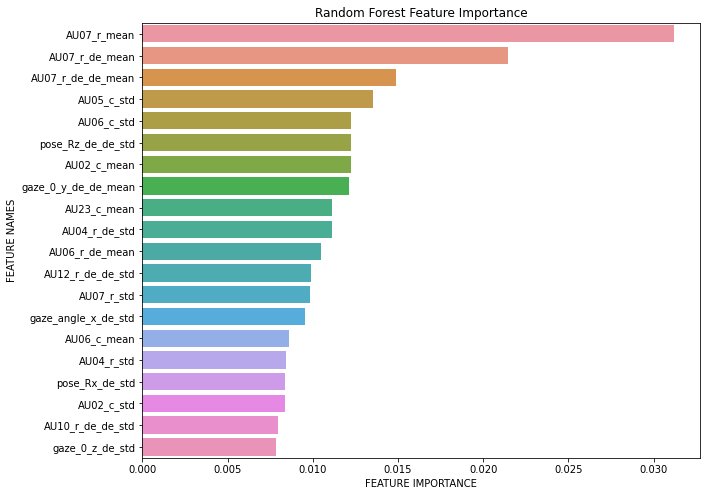

In [56]:
plot_feature_importance(grid.best_estimator_.feature_importances_,x.columns,'Random Forest') 

In [61]:
#SANS SPATIAL

In [63]:
spatial_features = ['gaze_0_x_de_mean',
       'gaze_0_x_de_std', 'gaze_0_x_de_de_mean', 'gaze_0_x_de_de_std',
       'gaze_0_y_de_mean', 'gaze_0_y_de_std', 'gaze_0_y_de_de_mean',
       'gaze_0_y_de_de_std', 'gaze_0_z_de_mean', 'gaze_0_z_de_std',
       'gaze_0_z_de_de_mean', 'gaze_0_z_de_de_std', 'gaze_1_x_de_mean',
       'gaze_1_x_de_std', 'gaze_1_x_de_de_mean', 'gaze_1_x_de_de_std',
       'gaze_1_y_de_mean', 'gaze_1_y_de_std', 'gaze_1_y_de_de_mean',
       'gaze_1_y_de_de_std', 'gaze_1_z_de_mean', 'gaze_1_z_de_std',
       'gaze_1_z_de_de_mean', 'gaze_1_z_de_de_std', 'gaze_angle_x_de_mean',
       'gaze_angle_x_de_std', 'gaze_angle_x_de_de_mean',
       'gaze_angle_x_de_de_std', 'gaze_angle_y_de_mean', 'gaze_angle_y_de_std',
       'gaze_angle_y_de_de_mean', 'gaze_angle_y_de_de_std', 'pose_Tx_de_mean',
       'pose_Tx_de_std', 'pose_Tx_de_de_mean', 'pose_Tx_de_de_std',
       'pose_Ty_de_mean', 'pose_Ty_de_std', 'pose_Ty_de_de_mean',
       'pose_Ty_de_de_std', 'pose_Tz_de_mean', 'pose_Tz_de_std',
       'pose_Tz_de_de_mean', 'pose_Tz_de_de_std', 'pose_Rx_de_mean',
       'pose_Rx_de_std', 'pose_Rx_de_de_mean', 'pose_Rx_de_de_std',
       'pose_Ry_de_mean', 'pose_Ry_de_std', 'pose_Ry_de_de_mean',
       'pose_Ry_de_de_std', 'pose_Rz_de_mean', 'pose_Rz_de_std',
       'pose_Rz_de_de_mean', 'pose_Rz_de_de_std']

In [67]:
x_only_AUC = x.drop(spatial_features, axis =1)
x_only_AUC.columns

Index(['sexe', 'AU01_r_mean', 'AU01_r_std', 'AU02_r_mean', 'AU02_r_std',
       'AU04_r_mean', 'AU04_r_std', 'AU05_r_mean', 'AU05_r_std', 'AU06_r_mean',
       'AU06_r_std', 'AU07_r_mean', 'AU07_r_std', 'AU09_r_mean', 'AU09_r_std',
       'AU10_r_mean', 'AU10_r_std', 'AU12_r_mean', 'AU12_r_std', 'AU14_r_mean',
       'AU14_r_std', 'AU15_r_mean', 'AU15_r_std', 'AU17_r_mean', 'AU17_r_std',
       'AU20_r_mean', 'AU20_r_std', 'AU23_r_mean', 'AU23_r_std', 'AU25_r_mean',
       'AU25_r_std', 'AU26_r_mean', 'AU26_r_std', 'AU45_r_mean', 'AU45_r_std',
       'AU01_c_mean', 'AU01_c_std', 'AU02_c_mean', 'AU02_c_std', 'AU04_c_mean',
       'AU04_c_std', 'AU05_c_mean', 'AU05_c_std', 'AU06_c_mean', 'AU06_c_std',
       'AU07_c_mean', 'AU07_c_std', 'AU09_c_mean', 'AU09_c_std', 'AU10_c_mean',
       'AU10_c_std', 'AU12_c_mean', 'AU12_c_std', 'AU14_c_mean', 'AU14_c_std',
       'AU15_c_mean', 'AU15_c_std', 'AU17_c_mean', 'AU17_c_std', 'AU20_c_mean',
       'AU20_c_std', 'AU23_c_mean', 'AU23_c_std', 'A

In [68]:
from sklearn.model_selection import LeaveOneGroupOut

groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x_only_AUC, y, groups)

##Looking for the best parameters for Random forest, evaluated with accuracy and leave one group out
from sklearn.ensemble import RandomForestClassifier
params = { 'n_estimators': [50, 100, 200],'max_depth': [4, 6], 'max_features':['sqrt', "log2", 0.2]}


rf = RandomForestClassifier(random_state = 42) 

grid = GridSearchCV(estimator = rf, param_grid=params, scoring={'accuracy_score' : 'accuracy', 'f1_score' : 'f1_weighted' }, refit='accuracy_score', cv=cv_loo)
grid.fit(x_only_AUC, y)
print('Best results', grid.best_score_)
print('Best params', grid.best_params_)

Best results 0.4870689655172414
Best params {'max_depth': 4, 'max_features': 0.2, 'n_estimators': 50}


In [69]:
##Looking for the best parameters for Random forest, evaluated with accuracy and leave one group out
groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x_only_AUC, y, groups)
params = { 'n_estimators': [50, 100, 200],'max_depth': [4, 6], 'max_features':['sqrt', "log2", 0.2]}


rf = RandomForestClassifier(random_state = 42) 

grid = GridSearchCV(estimator = rf, param_grid=params, scoring={'accuracy_score' : 'accuracy', 'f1_score' : 'f1_weighted' }, refit='f1_score', cv=cv_loo)
grid.fit(x_only_AUC, y)
print('Best results', grid.best_score_)
print('Best params', grid.best_params_)

Best results 0.4414016060567784
Best params {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}


## 3 JUNE 2021, ADDING FIRST AND SECOND DERIVATIVES TIME WINDOW


In [13]:
df_with_deriv = []
for i in list_df_max:
    to_drop = ['frame','face_id','timestamp','confidence','success', 'type_candidat']
    i = add_frameTimeWindow(i)
    i = i.drop(to_drop, axis = 1)
    i = add_derivatives_drop_spatial(i)
    df_with_deriv.append(i)


In [14]:
groupby_features= ['video_name','stress_global','stress','frameTimeWindow','sexe']

df_total = pd.concat(df_with_deriv)
df_total = df_total.drop('diapo', axis = 1)


In [15]:

df_total = df_total.groupby(groupby_features).agg(['mean']).reset_index()
df_total.columns= df_total.columns.map('_'.join).str.strip('_')
df_total[['stress']].value_counts()

stress
1.0       2377
0.0       2015
2.0        633
3.0         20
dtype: int64

In [16]:
x = df_total.drop(['video_name','stress_global',	'stress','frameTimeWindow'], axis = 1)


In [17]:
#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df_total[['stress']]



from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

y_train = y_train.values.squeeze()
y_test = y_test.values.squeeze()


In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)


print("F1 score = ", f1_score(y_test, y_pred, average='weighted'))

F1 score =  0.7766900508619785


In [62]:
## SPLIT TRAIN AND TEST W RT VIDEOS

In [63]:
video_names_train = video_names[0:21]

In [65]:
video_names_test =  video_names[21:]

In [66]:
df_total_drop = df_total.drop(['stress_global','frameTimeWindow'], axis = 1)
df_total_drop.sexe = df_total_drop.sexe.replace('H',0)
df_total_drop.sexe = df_total_drop.sexe.replace('F',1)

In [69]:
 df_train = df_total_drop[df_total_drop["video_name"].isin(video_names_train)]

In [70]:
df_test =df_total_drop[df_total_drop["video_name"].isin(video_names_test)]

In [71]:
x_train = df_train.drop(['stress', 'video_name'], axis =1)
y_train = df_train[['stress']]
x_test = df_test.drop(['stress', 'video_name'], axis =1)
y_test = df_test[['stress']]




y_train = y_train.values.squeeze()
y_test = y_test.values.squeeze()

In [72]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)


print("F1 score = ", f1_score(y_test, y_pred, average='weighted'))

F1 score =  0.37453722297806136


## 8 JUIN 2021, CV WITH LEAVE ONE VIDEO OUT 

In [19]:
list_df_max = []
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations('/Users/valentinadiproietto/OpenFace/processed/', v_name, filename_annotations, "max")
    list_df_max.append(eliminate_features(df_annoted))

100%|██████████| 29/29 [02:39<00:00,  5.49s/it]


In [35]:
df_with_deriv = []
for i in list_df_max:
    to_drop = ['frame','face_id','timestamp','confidence','success', 'type_candidat']
    i = add_frameTimeWindow(i)
    i = i.drop(to_drop, axis = 1)
    i = add_derivatives_drop_spatial(i)
    df_with_deriv.append(i)

In [36]:
groupby_features= ['video_name','stress_global','stress','frameTimeWindow','sexe']

df_total = pd.concat(df_with_deriv)
df_total = df_total.drop('diapo', axis = 1)

df_total = df_total.groupby(groupby_features).agg(['mean']).reset_index()
df_total.columns= df_total.columns.map('_'.join).str.strip('_')


In [37]:
y = pd.concat([df_total[['stress']], df_total[['video_name']]], axis = 1 )
x = df_total.drop(['stress_global',	'stress','frameTimeWindow'], axis = 1)
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

In [38]:
from sklearn.model_selection import LeaveOneGroupOut

groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x, y, groups)


In [39]:
x_no_name = x.drop(['video_name'], axis = 1)
y_no_name = y.drop(['video_name'], axis = 1)


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

model = RandomForestClassifier(random_state = 42)
y_pred= cross_val_predict(model, x_no_name, y_no_name, cv=cv_loo)

In [41]:
print("F1 score = ", f1_score(y_no_name, y_pred, average='weighted'))
print('accuracy = ', )

F1 score =  0.4247932417279817
accuracy = 


# TUNING HYPERPARAMETERS

In [28]:
##Looking for the best parameters for Random forest, evaluated with accuracy and leave one group out

params = { 'n_estimators': [50, 100, 200],'max_depth': [4, 6], 'max_features':['sqrt', "log2", 0.2]}


rf = RandomForestClassifier(random_state = 42) 

grid = GridSearchCV(estimator = rf, param_grid=params, scoring={'accuracy_score' : 'accuracy', 'f1_score' : 'f1_weighted' }, refit='accuracy_score', cv=cv_loo)
grid.fit(x_no_name, y_no_name)

GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7ff0582b3a50>,
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 6],
                         'max_features': ['sqrt', 'log2', 0.2],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy_score',
             scoring={'accuracy_score': 'accuracy', 'f1_score': 'f1_weighted'})

In [29]:
print('Best results', grid.best_score_)
print('Best params', grid.best_params_)

Best results 0.46360566791955415
Best params {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 50}


In [30]:
#take the model with the best parameters
grid.best_estimator_

RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=50,
                       random_state=42)

In [43]:
#predict with the best model of above, and with Leave one Group out.

from sklearn.model_selection import cross_val_predict

groups = df_total['video_name']
loo = LeaveOneGroupOut()

cv_loo = loo.split(x, y, groups)

y_pred= cross_val_predict(grid.best_estimator_, x_no_name, y_no_name, cv=cv_loo)

## PREDICT GLOBAL STRESS, adding to the dataframe of 5timewindow the column with the predictions made on each time window, then group by video_name aggregate everything by mean and make the prediction with leave one video out

In [76]:
y_pred
y_pred_pd = pd.Series(y_pred)
y_pred_pd.name = "pred"


In [77]:
#This is x at which I have added a last column with the prediction for each 5 seconds
x_with_predict_5 = pd.concat([x, y_pred_pd], axis = 1)
y_stress_global =pd.concat([df_total['stress_global'], df_total['video_name']], axis = 1)

In [111]:
#aggregate by video_name to predict stress global
x_aggregated = x_with_predict_5.groupby('video_name').agg(['mean']).reset_index()
x_aggregated.columns = x_aggregated.columns.map('_'.join).str.strip('_')
y_aggregated = y_stress_global.groupby('video_name').agg(['mean']).reset_index()
y_aggregated.columns = y_aggregated.columns.map('_'.join).str.strip('_')
print(y_aggregated.shape)
print(x_aggregated.shape)

(29, 2)
(29, 100)


In [118]:

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
print(loo.get_n_splits(y_aggregated))
cv_loo = loo.split(y_aggregated)


x_aggregated_no_name = x_aggregated.drop('video_name', axis = 1)
y_aggregated_no_name = y_aggregated.drop('video_name', axis = 1).values

##Looking for the best parameters for Random forest, evaluated with accuracy and leave one group out

params = { 'n_estimators': [50, 100, 200],'max_depth': [4, 6], 'max_features':['sqrt', "log2", 0.2]}


rf = RandomForestClassifier(random_state = 42) 

grid = GridSearchCV(estimator = rf, param_grid=params, scoring={'accuracy_score' : 'accuracy', 'f1_score' : 'f1_weighted' }, refit='accuracy_score', cv=cv_loo)
grid.fit(x_aggregated_no_name, y_aggregated_no_name)

29


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7fede8a46050>,
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 6],
                         'max_features': ['sqrt', 'log2', 0.2],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy_score',
             scoring={'accuracy_score': 'accuracy', 'f1_score': 'f1_weighted'})

In [119]:
print('Best results', grid.best_score_)
print('Best params', grid.best_params_)

Best results 0.41379310344827586
Best params {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}


In [ ]:
# here is the SAME IDE BUT DONE TWIE